In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
from Data import get_setup
import os
from datetime import datetime
import timeit

import torch.nn.functional as F
import torch
from torch import nn
from torch.utils.data import Dataset
from tqdm import trange
from Data import get_setup
from Inference_new import *
from Models.VI import *
from Tools import uniform_rect_sampler
import argparse


In [3]:
device =torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


In [4]:
## small ##
# predictive model architecture
layerwidth = 50
nblayers = 1
activation = nn.ReLU()



In [5]:
path="Results/Paper/Exp2/Exp2_small2021-01-28-00:59"

In [8]:
MODELS=torch.load(path+"_models.pt",map_location=device)
for dataset in datasets:
    print(dataset+": {}".format(len(MODELS[dataset])))

boston: 10
concrete: 10
energy: 10
wine: 10
yacht: 10


In [7]:
datasets = ['boston', 'concrete', 'energy','wine','yacht']
# for key in MODELS.keys():
#     datasets.append(key)

methods=[ 'MC dropout','Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']
# for key in MODELS['energy'][0][1].keys():
#     methods.append(key)
    
datasets, methods

(['boston', 'concrete', 'energy', 'wine', 'yacht'],
 ['MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI'])

In [9]:
from Metrics import rmse, lpp, lpp_gaussian
def get_metrics(y_pred, sigma_noise, y_test, std_y_train, time, gaussian_prediction=False):
    metrics = {}
    rmse_test, _ = rmse(y_pred.mean(dim=0).cpu(), y_test.cpu(), std_y_train.cpu())
    metrics.update({'RMSE': rmse_test})

    if gaussian_prediction:
        lpp_test, _ = lpp_gaussian(y_pred.cpu(), y_test.cpu(), sigma_noise.cpu(), std_y_train.cpu())
    else:
        lpp_test, _ = lpp(y_pred.cpu(), y_test.cpu(), sigma_noise.view(1, 1, 1).cpu(), std_y_train.cpu())

    metrics.update({'LPP': lpp_test})
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    return metrics

In [10]:
results=[]

for dataset in datasets:   

    for split in MODELS[dataset]:
        split_results={}
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']

        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test)
        metrics = get_metrics(y_pred, torch.tensor(0.), y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model.predict(x_test, 1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2], gaussian_prediction=True)
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
            
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        y_pred=model(x_test,1000)
        metrics = get_metrics(y_pred, model.sigma_noise, y_test, std_y_train, split[1][method][2])
        metrics.update({'dataset':dataset,'method':method})
        results.append(metrics)
        
        #Results.append({dataset:split_results})

In [11]:
torch.save(results,path+'_results.pt')

# RMSE

In [12]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','RMSE']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis_r')
#df_.style.highlight_min(axis=1)


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
boston,3.444975,3.393448,3.807834,4.263033,3.769535,3.733011
concrete,4.706556,4.126360,5.108250,5.644193,4.719620,4.749167
energy,0.565759,0.410518,0.462742,0.572870,0.436703,0.457069
wine,0.629738,0.640798,0.650321,0.674266,0.736295,0.695587
yacht,0.737363,0.680147,1.152559,1.708311,0.599475,0.911044


In [13]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [14]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &   MC dropout &     Ensemble &         MFVI &    FuNN-MFVI &      NN-HyVI &    FuNN-HyVI \\
dataset  &              &              &              &              &              &              \\
\midrule
boston   &  3.445±0.342 &  3.393±0.339 &  3.808±0.249 &  4.263±0.476 &   3.77±0.477 &  3.733±0.229 \\
concrete &  4.707±0.177 &  4.126±0.227 &  5.108±0.151 &  5.644±0.235 &    4.72±0.16 &  4.749±0.266 \\
energy   &  0.566±0.021 &  0.411±0.021 &  0.463±0.022 &  0.573±0.034 &  0.437±0.039 &   0.457±0.04 \\
wine     &   0.63±0.014 &  0.641±0.017 &   0.65±0.014 &  0.674±0.012 &  0.736±0.015 &  0.696±0.019 \\
yacht    &  0.737±0.074 &    0.68±0.07 &  1.153±0.074 &  1.708±0.168 &  0.599±0.066 &  0.911±0.092 \\
\bottomrule
\end{tabular}



# LPP

In [15]:
import pandas as pd

df=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).mean()#.transpose()
df_sem=pd.DataFrame(results).loc[:,['dataset','method','LPP']].groupby(['dataset','method']).sem()

def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: x[1])
    return df

df_=collapse_columns(df.unstack()).reindex(columns=methods)
df_sem_=collapse_columns(df_sem.unstack()).reindex(columns=methods)
df_.style.background_gradient(axis=1,cmap='viridis')
#df_.style.highlight_max(axis=1)


,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
dataset,,,,,,
boston,-6.788178,-4.242977,-2.829286,-7.610205,-4.499601,-13.085541
concrete,-5.376995,-6.191169,-3.084943,-3.620637,-3.264159,-3.597451
energy,-1.001988,-1.785005,-0.665173,-1.308607,-0.567198,-0.870031
wine,-11.671109,-2.352902,-0.991279,-1.196186,-1.359147,-1.454882
yacht,-0.593607,-0.797440,-1.654285,-4.658845,-0.974485,-4.203983


In [16]:
for i in df_.columns:
    df_[i] = df_[i].round(3).astype(str)+ "±" + (df_sem_[i].round(3)).astype(str)+""

In [17]:
print(df_.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &    MC dropout &      Ensemble &          MFVI &     FuNN-MFVI &       NN-HyVI &      FuNN-HyVI \\
dataset  &               &               &               &               &               &                \\
\midrule
boston   &  -6.788±0.681 &  -4.243±0.304 &  -2.829±0.101 &    -7.61±2.31 &    -4.5±0.935 &  -13.086±1.207 \\
concrete &   -5.377±0.31 &  -6.191±1.566 &  -3.085±0.041 &  -3.621±0.143 &  -3.264±0.107 &   -3.597±0.217 \\
energy   &  -1.002±0.047 &  -1.785±0.281 &  -0.665±0.048 &  -1.309±0.128 &  -0.567±0.079 &    -0.87±0.209 \\
wine     &  -11.671±1.23 &  -2.353±0.193 &  -0.991±0.024 &  -1.196±0.041 &  -1.359±0.051 &   -1.455±0.066 \\
yacht    &  -0.594±0.034 &  -0.797±0.394 &  -1.654±0.124 &  -4.659±0.529 &  -0.974±0.264 &   -4.204±1.201 \\
\bottomrule
\end{tabular}



# displaying logs

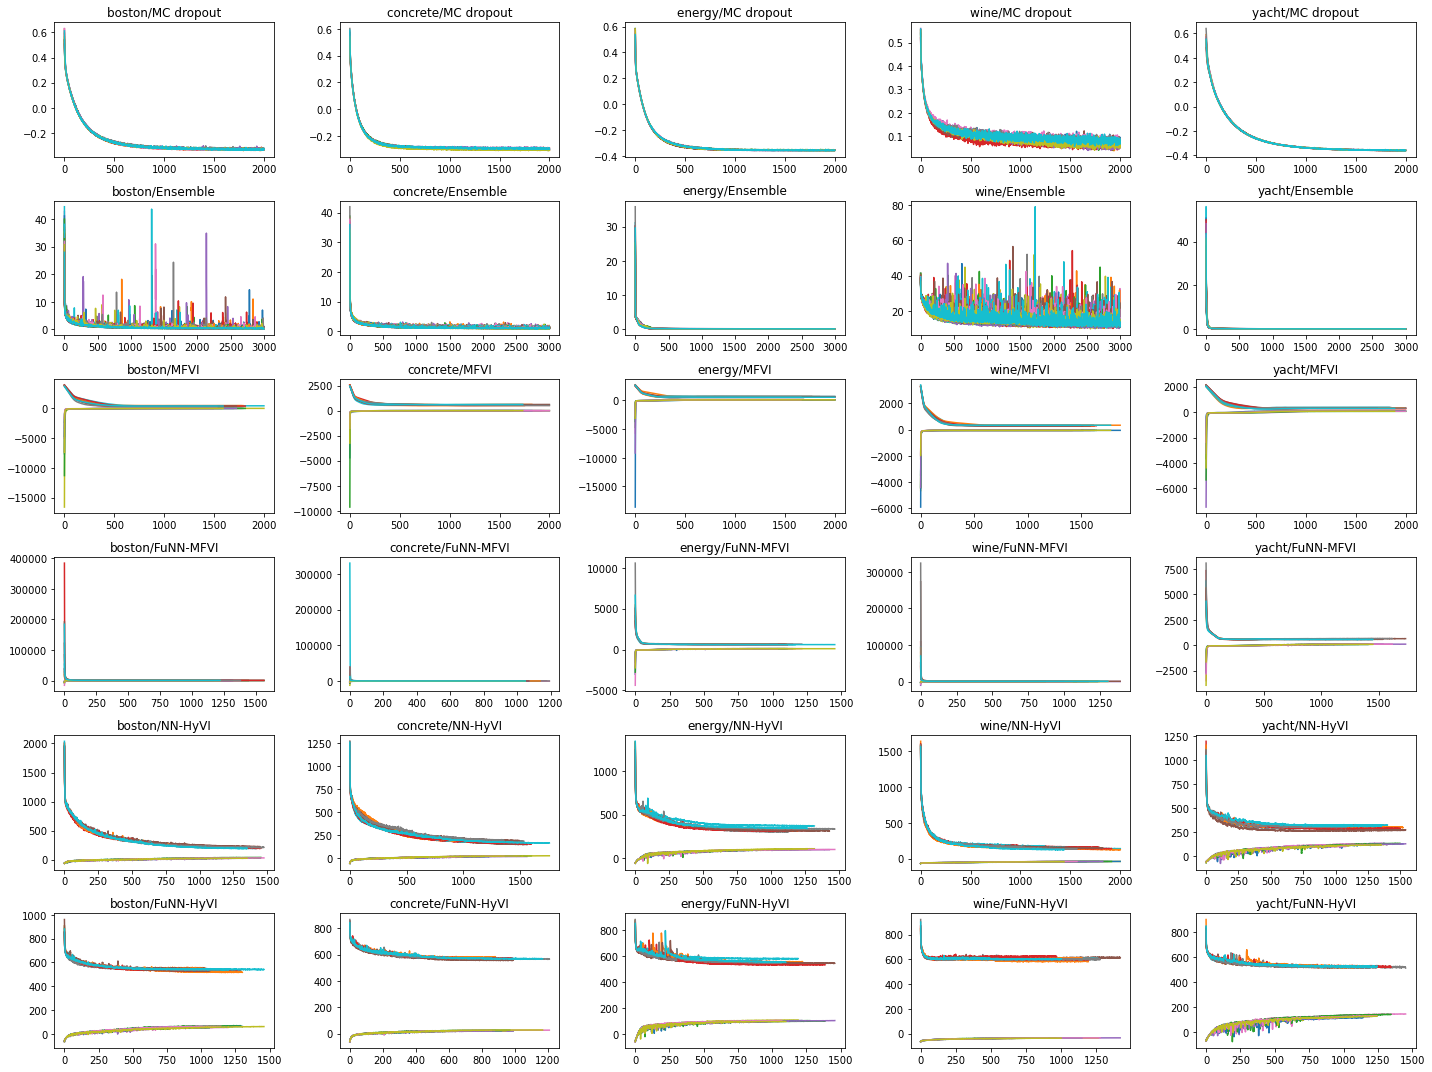

In [18]:
from pylab import *
fig, ax=plt.subplots(len(methods), len(datasets), figsize=(20,15))
ax=ax.flatten()
i=0
for method in methods:
    for dataset in datasets:
        for split in MODELS[dataset]: 
            logs=split[1][method][1]
            for key in logs.keys():
                if key=='KL' or key=='loss' or key=='LL' or isinstance(key, int): 
                    ax[i].plot(range(len(logs[key])), logs[key])
                #ax[i].legend()
                ax[i].set_title(dataset+'/'+method)
        i+=1

fig.tight_layout()

# OOD detection

In [19]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

VARs={dataset:{method: [] for method in methods} for dataset in datasets}
#Hs=torch.load(path+'_epist_entropy_50k.pt')
#MODELS.to(device)
def VAR(model, X):
#    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]
    return [torch.cat([model(x_, 1000).detach().std(0).squeeze() for x_ in x.split(500,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)

for dataset in datasets:
    print(dataset)
    split_nb=0
    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=50000)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Y = [model(x) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
        Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
        #Y=[model.predict(x, 1000) for x in X]
        VARs[dataset][method].append([y.std(0).squeeze() for y in Y])
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        VARs[dataset][method].append(VAR(model,X))
        
        torch.save(VARs,path+'_epist_VAR_50k.pt')

boston
0
1
2
3
4
5
6
7
8
9
concrete
0
1
2
3
4
5
6
7
8
9
energy
0
1
2
3
4
5
6
7
8
9
wine
0
1
2
3
4
5
6
7
8
9
yacht
0
1
2
3
4
5
6
7
8
9


In [20]:
VARs=torch.load(path+'_epist_VAR_50k.pt')
from sklearn.metrics import roc_curve, roc_auc_score
from pylab import *
import numpy as np
cmap=plt.get_cmap('Set1')
Hs=VARs
roc_data={dataset:{} for dataset in datasets}
AUC={}#{dataset:{} for dataset in datsets}

fpr=torch.arange(50000).true_divide(50000)

for dataset in datasets:     
    for method in methods:
        AUCs=[]

        TPRs=[]
        for h in Hs[dataset][method]:
            H_in=torch.cat([h[0],h[1]]).cpu()
            H_ood, _=h[2].cpu().sort()
            TPRs.append((H_in.unsqueeze(-1) < H_ood).sum(0).true_divide(len(H_in)))

            y_true=torch.cat([torch.ones_like(torch.cat([h[0],h[1]])),torch.zeros_like(h[2])])
            y_score=-torch.cat([h[0],h[1],h[2]])
            AUCs.append(roc_auc_score(y_true.cpu(), y_score.cpu()))
        roc_data[dataset].update({method: {'AUC':np.mean(AUCs),'tpr_mean': torch.stack(TPRs).mean(0), 'tpr_min':torch.stack(TPRs).min(0)[0], 'tpr_max':torch.stack(TPRs).max(0)[0]}})

        print(dataset+"/"+method+": {}".format(np.mean(AUCs)))

boston/MC dropout: 0.9386483221343873
boston/Ensemble: 0.9994067430830039
boston/MFVI: 0.96025545256917
boston/FuNN-MFVI: 0.9922482529644269
boston/NN-HyVI: 0.9984038596837944
boston/FuNN-HyVI: 0.999661162055336
concrete/MC dropout: 0.9516246990291263
concrete/Ensemble: 0.9991481747572817
concrete/MFVI: 0.9336183233009707
concrete/FuNN-MFVI: 0.972871786407767
concrete/NN-HyVI: 0.9975687203883495
concrete/FuNN-HyVI: 0.9972593980582524
energy/MC dropout: 0.7736824726562499
energy/Ensemble: 0.9999840703124999
energy/MFVI: 0.4263981432291667
energy/FuNN-MFVI: 0.9451755664062501
energy/NN-HyVI: 0.9998925104166666
energy/FuNN-HyVI: 0.9996696328125001
wine/MC dropout: 0.992337153846154
wine/Ensemble: 0.9985408799249532
wine/MFVI: 0.9943050187617262
wine/FuNN-MFVI: 0.9965282470293934
wine/NN-HyVI: 0.9991510619136961
wine/FuNN-HyVI: 0.9997717010631645
yacht/MC dropout: 0.5266416331168832
yacht/Ensemble: 0.9947091883116883
yacht/MFVI: 0.5281007272727272
yacht/FuNN-MFVI: 0.9242346396103895
yacht/

<ipython-input-21-5cddcf17bed3>:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


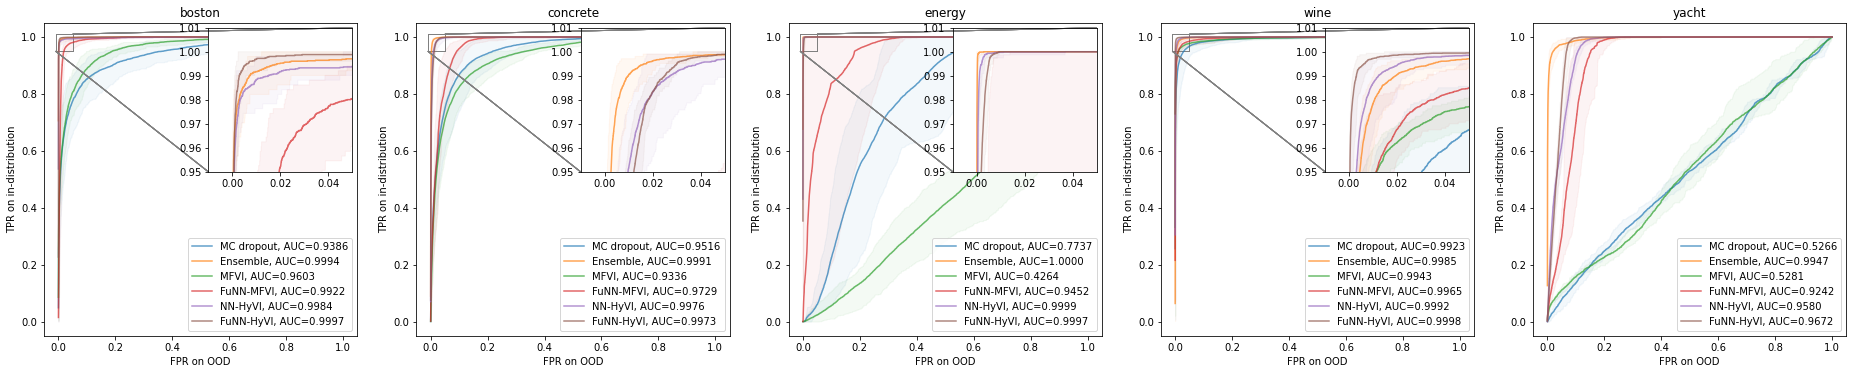

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset
from matplotlib.colors import ListedColormap

from pylab import *
import seaborn as sns
l=len(datasets)
fig, ax= plt.subplots(1,l,figsize=(5*l+1,5))
d=0
cmap=ListedColormap(sns.color_palette("tab10").as_hex())
R=[0.05, 0.05, 0.05,0.05, 0.05,]
B=[0.95, 0.95, 0.95, 0.95, 0.95]

fpr=torch.arange(50000).true_divide(50000)
colors=[]
for dataset in datasets:
    c=0
    if not dataset=='yacht':
        zoom_ax = inset_axes(ax[d], width=2, height=2,  loc='upper right')      
    for method in methods:
        AUC=roc_data[dataset][method]['AUC']
        tpr_mean=roc_data[dataset][method]['tpr_mean']
        tpr_min=roc_data[dataset][method]['tpr_min']
        tpr_max=roc_data[dataset][method]['tpr_max']
        ax[d].plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
        ax[d].fill_between(fpr, tpr_min, tpr_max, alpha=0.05, color=cmap(c))
        #custom_text.append(method+' (AUC:{})'.format(np.mean(AUCs).round(3)))
    #lgd = ax[d].legend(custom_lines, custom_text, loc='best')

  #'upper right')#width="40%", height="40%",
        if not dataset=='yacht':
            zoom_ax.plot(fpr, tpr_mean, alpha=0.7, label=method+", AUC={:.4f}".format(AUC), color=cmap(c))
            zoom_ax.fill_between(fpr, tpr_min, tpr_max, alpha=0.05, color=cmap(c))  
            mark_inset(ax[d], zoom_ax, loc1=1, loc2=3, fc="none", ec="0.5")

        c+=1
    zoom_ax.set_xlim(left=-0.01, right=R[d])
    zoom_ax.set_ylim(bottom=B[d], top=1.01)
    zoom_ax.legend().remove()
    zoom_ax.set_xlabel('')
    zoom_ax.set_ylabel('')
    zoom_ax.set_aspect('equal')
    ax[d].legend()
    ax[d].set_title(dataset)
    ax[d].set_xlabel('FPR on OOD')
    ax[d].set_ylabel('TPR on in-distribution')
    ax[d].set_xlim(left=-0.05, right=1.05)
    ax[d].set_ylim(bottom=-.05, top=1.05)
    ax[d].set_aspect('equal')

    d+=1


fig.tight_layout()

In [22]:
plt.savefig(path+"ROC_curves_VAR_MinMax.pdf", dpi=600)


<Figure size 432x288 with 0 Axes>

In [24]:
torch.save(roc_data,path+'_roc_data_VAR10k.pt')
torch.save(AUC,path+'_AUC_VAR10k.pt')


# Parametric vs Predictor Entropy

In [26]:
from Metrics import entropy_nne
def FunH(model, sampler, n=100, n_MC=200):
    Hs=[entropy_nne(model(sampler()).squeeze(2), k=1, k_MC=n_MC).item() for _ in range(n)]
    return np.mean(Hs)



In [ ]:
import seaborn as sns
from pylab import *
import math
from Tools import uniform_rect_sampler
from Metrics import batch_entropy_nne

Hs={dataset:{} for dataset in datasets}

def Entropy(model, X):
    return [torch.cat([batch_entropy_nne(model(x_, 1000).detach().transpose(0,1), k=1) for x_ in x.split(500,dim=0)],dim=0) for x in X]

def univariate_gaussian_entropy(sigma=None, var=None):
    if sigma is not None:
        return 0.5*torch.log(2*math.pi*math.e*sigma**2)
    if var is not None:
        return 0.5*torch.log(2*math.pi*math.e*var)

nb_predictors=1000    
n_MC=200
    
for dataset in datasets:
    print(dataset)
    split_nb=0
    Hs[dataset].update({(method,'parameter'):[] for method in methods})
    Hs[dataset].update({(method,'predictor'):[] for method in methods})

    for split in MODELS[dataset]:#[MODELS[dataset][0]]:
        print(split_nb)
        split_nb+=1
        x_train, y_train=split[0]['train']
        x_test, y_test=split[0]['test']
        input_dim=x_test.shape[1]
        std_y_train=split[0]['scaler_y']
        
        OOD_sampler = uniform_rect_sampler(x_train, n=n_MC)
        x_OOD=OOD_sampler()
        
        X = [x_train, x_test, x_OOD]
        method="Ensemble"
        model = ensemble(input_dim, layerwidth, activation, num_models=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.get_parameters, k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(model, OOD_sampler, n=100, n_MC=200))

        method="MC dropout"
        model = MC_Dropout(input_dim, 1, layerwidth, init_sigma_noise=1., drop_prob=0.05, learn_noise=True,
                               activation=activation).to(device)
        model.load_state_dict(split[1][method][0])
      #  Y=[torch.cat([model.predict(x_, 1000).detach() for x_ in x.split(500,dim=0)],dim=1) for x in X]
#        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model.predict(x,nb_predictors), OOD_sampler, n=100, n_MC=200))
         
        method="MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="NN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))

        
        method="FuNN-HyVI"
        model = HyVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True,lat_dim=5).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        
        method="FuNN-MFVI"
        model = MFVI(input_dim, layerwidth, nblayers, activation, init_sigma_noise=1., learn_noise=True, std_mu_init=1., sigma_init=0.001).to(device)
        model.load_state_dict(split[1][method][0])
        Hs[dataset][(method,'parameter')].append(entropy_nne(model.gen(nb_predictors), k=1, k_MC=1).item())
        Hs[dataset][(method,'predictor')].append(FunH(lambda x: model(x,nb_predictors=nb_predictors), OOD_sampler, n=100, n_MC=200))
        

boston
0
1
2
3
4
5
6
7
8
9
concrete
0
1
2
3
4
5
6
7
8
9
energy
0


In [54]:
#torch.save(Hs,path+'_ParamVsPredictor_entropy.pt')
Hs=torch.load(path+'_ParamVsPredictor_entropy.pt')


In [55]:
import pandas as pd

H_mean={} 
H_std={}
for dataset, value in Hs.items():
    #print(dataset)
    H_mean.update({dataset:{}})
    H_std.update({dataset:{}})
    for key2, results in value.items():
        #print(key2)
        H_mean[dataset].update({key2:np.mean(results)})
        H_std[dataset].update({key2:np.std(results)})

/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [56]:
methods=['MC dropout', 'Ensemble', 'MFVI', 'FuNN-MFVI', 'NN-HyVI', 'FuNN-HyVI']
index=pd.MultiIndex.from_product([methods,["parameter"]]) 
pd.DataFrame(H_mean, index=index).transpose().style.background_gradient(axis=1,cmap='viridis')

,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,parameter,parameter,parameter,parameter,parameter,parameter
boston,nan,494.695557,519.099792,-1744.479370,1257.820166,-1318.742651
concrete,nan,530.439612,221.879736,-1227.944250,861.887488,-978.169379
energy,nan,202.969641,265.633252,-1035.920343,522.101733,-1532.986743
wine,nan,933.094531,445.239038,-1231.157825,1371.691846,-996.576874
yacht,nan,169.060718,236.261401,-773.676501,337.722174,-933.490735


In [57]:
pd.DataFrame(H_std, index=index).transpose()

,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,parameter,parameter,parameter,parameter,parameter,parameter
boston,NaN,16.246284,11.229295,129.975918,24.083430,64.418440
concrete,NaN,12.147546,19.735302,118.936451,29.689146,45.196776
energy,NaN,9.726949,18.536246,112.261839,29.964477,48.610808
wine,NaN,19.226589,10.917981,106.365041,48.170744,66.588951
yacht,NaN,8.718515,8.216051,105.994701,24.640968,38.939815


In [58]:
index=pd.MultiIndex.from_product([methods,["predictor"]])
pd.DataFrame(H_mean, index=index).transpose().style.background_gradient(axis=1,cmap='viridis')

,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,predictor,predictor,predictor,predictor,predictor,predictor
boston,-492.871071,-103.531046,-628.211356,-411.762016,-517.815761,-241.457668
concrete,-404.651742,-153.728828,-694.239495,-395.910157,-406.746364,-258.603589
energy,-479.027143,-297.761832,-1145.490795,-367.634764,-381.781488,-304.311555
wine,-234.660888,49.860649,-486.684596,-331.839532,-240.830521,-250.612952
yacht,-812.228689,-531.750886,-1067.693759,-346.540100,-654.076560,-280.667854


In [59]:
pd.DataFrame(H_std, index=index).transpose()

,MC dropout,Ensemble,MFVI,FuNN-MFVI,NN-HyVI,FuNN-HyVI
,predictor,predictor,predictor,predictor,predictor,predictor
boston,17.106381,18.536717,20.191100,31.656314,20.532112,9.751009
concrete,56.561752,9.810073,16.101911,29.528168,33.912849,4.311384
energy,41.278838,33.736889,12.171425,43.236065,49.635688,13.630734
wine,19.387749,13.443909,27.432887,14.865089,36.915504,6.279533
yacht,11.488662,25.312682,32.807081,38.272762,37.044823,3.664877
